In [ ]:
## Data Initializing

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [17]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/user/model.py'>

# Beckmann model

parameter $\mu = 0.25$

In [2]:
beckmann_save = 'beckmann_results/'

In [3]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Frank-Wolfe algorithm

In [7]:
assert(model.mu == 0.25)
max_iter = 10

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter': max_iter}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

with open(beckmann_save + 'anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

Frank-Wolfe without stopping criteria
Oracles created...
Frank-Wolfe algorithm...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
iterations number exceeded total iters: 10
Primal_func_value = 1.28666e+06
Duality_gap / Duality_gap_init = 0.0161514
Phi_big_oracle elapsed time: 6 sec
Elapsed time: 6 sec
Time ratio = 3.2936307809439356
Flow excess = 0.9734031986531992



__Checking the result with the answer from https://github.com/bstabler/TransportationNetworks__ 

In [8]:
with open('anaheim_check_answer_fwa.pickle', 'wb') as f:
    pickle.dump(result, f)

In [9]:
answer = handler.ReadAnswer('Anaheim_flow.tntp')
with open('anaheim_check_answer_fwa.pickle', 'rb') as f:
    result = pickle.load(f)
delta = abs(answer['flows'] - result['flows'])
print('Flows:')
print('total_od_flow =', total_od_flow)
print(np.min(delta))
print(np.max(delta))
print(np.linalg.norm(result['flows'] - answer['flows'], ord = 1) / np.linalg.norm(answer['flows'], ord = 1))
print(np.linalg.norm(delta) / total_od_flow)
print('Times:')
delta = abs(answer['times'] - result['times'])
print(np.min(delta))
print(np.max(delta))
print(np.sum(delta))

Flows:
total_od_flow = 104694.4
0.0
30.348124879227214
0.00019851463350225587
0.0006234140736819147
Times:
0.0
0.0003401170987493707
0.004375891976431269


## Universal Similar Triangles

In [6]:
assert(model.mu == 0.25)
max_iter = 100 #10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'ustf' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Oracles created...
Universal similar triangles function...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 100
Inner iterations number: 203
Primal_func_value = 1.2862e+06
Dual_func_value = -1.28561e+06
Duality_gap = 595.715
Duality_gap / Duality_gap_init = 0.012428
iterations number exceeded total iters: 100
Primal_func_value = 1.2862e+06
Duality_gap / Duality_gap_init = 0.012428
Phi_big_oracle elapsed time: 53 sec
Elapsed time: 53 sec
Time ratio = 3.056682481292377
Flow excess = 1.1421158659098691

eps_abs = 31.622776601683793
Oracles created...
Universal similar triangles function...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 100
Inner iterations number: 196
Primal_func_value = 1.28607e+06
Dual_func_value = -1.28591e+06
Duality_gap = 163.228
Duality_gap / Duality_gap_init = 0.0034053
iterations number exceeded total iters: 100
Primal_func_value = 1.28607e+06
Duality

## Universal Gradient Descent

In [10]:
assert(model.mu == 0.25)
max_iter = 100
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'ugd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + '_beckman.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 100
Inner iterations number: 222
Primal_func_value = 1.29003e+06
Dual_func_value = -1.28487e+06
Duality_gap = 5164.7
Duality_gap / Duality_gap_init = 0.107747
iterations number exceeded total iters: 100
Primal_func_value = 1.29003e+06
Duality_gap / Duality_gap_init = 0.107747
Phi_big_oracle elapsed time: 104 sec
Elapsed time: 104 sec
Time ratio = 2.3784725291314786
Flow excess = 1.465872695951766

eps_abs = 31.622776601683793
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 100
Inner iterations number: 220
Primal_func_value = 1.28916e+06
Dual_func_value = -1.28526e+06
Duality_gap = 3907.5
Duality_gap / Duality_gap_init = 0.0815193
iterations number exceeded total iters: 100
Primal_func_value = 1.28916e+06
Duality_gap / Duality_gap

## Subgradient Descent (composite)

In [6]:
assert(model.mu == 0.25)
max_iter = 1000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = True)
    toc = time.time()
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'sd_composite' + '_#' + str(i) + '_max_iter_' + str(max_iter) +
              '_beckman.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Oracles created...
Subgradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 100
Primal_func_value = 1.29606e+06
Dual_func_value = -1.24844e+06
Duality_gap = 47368.2
Duality_gap / Duality_gap_init = 0.988208

Iterations number: 200
Primal_func_value = 1.29606e+06
Dual_func_value = -1.24868e+06
Duality_gap = 46924.4
Duality_gap / Duality_gap_init = 0.978951

Iterations number: 300
Primal_func_value = 1.29594e+06
Dual_func_value = -1.24891e+06
Duality_gap = 46411.4
Duality_gap / Duality_gap_init = 0.968248

Iterations number: 400
Primal_func_value = 1.29573e+06
Dual_func_value = -1.24912e+06
Duality_gap = 45846.7
Duality_gap / Duality_gap_init = 0.956468

Iterations number: 500
Primal_func_value = 1.29562e+06
Dual_func_value = -1.24932e+06
Duality_gap = 45391.9
Duality_gap / Duality_gap_init = 0.946978

Iterations number: 600
Primal_func_value = 1.29554e+06
Dual_func_value = -1.2495e+06
Duality_gap = 44994.9
Du

KeyboardInterrupt: 

## Subgradient Descent (non-composite)

### experiments for Beckman model ends here.

### For Stable Dynamic the cell below:

In [3]:
handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_data['graph_table']['capacity'] = graph_data['graph_table']['capacity'] # * 2.5

model = md.Model(graph_data, graph_correspondences, 
                 total_od_flow, mu = 0, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Experiment relative error vs gamma

### flow_star calculation for 2.5x capacity:

In [4]:
flows = []
times = []
iter_nums = []
primal_vals = []
dual_vals = []
dual_gaps = []

In [5]:
np.logspace(1,3,5)

array([  10.        ,   31.6227766 ,  100.        ,  316.22776602,
       1000.        ])

In [6]:
max_iter = 1000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    break
    #with open('anaheim_result_' + 'ustf' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
    #          '_2.5xCapacity.pickle', 'wb') as f:
    #    pickle.dump(result, f)

eps_abs = 10.0
Oracles created...
Universal similar triangles function...
Primal_init = 1.24813e+06
Dual_init = -1.24846e+06
Duality_gap_init = -334.271

Iterations number: 1
Inner iterations number: 1
Primal_func_value = 1.24813e+06
Dual_func_value = -1.24846e+06
Duality_gap = -334.271
Duality_gap / Duality_gap_init = 1

Iterations number: 100
Inner iterations number: 272
Primal_func_value = 1.43765e+06
Dual_func_value = -4.6598e+08
Duality_gap = -4.64542e+08
Duality_gap / Duality_gap_init = 1.38972e+06

Iterations number: 200
Inner iterations number: 570
Primal_func_value = 1.45434e+06
Dual_func_value = -1.33103e+10
Duality_gap = -1.33089e+10
Duality_gap / Duality_gap_init = 3.98146e+07

Iterations number: 300
Inner iterations number: 862
Primal_func_value = 1.56335e+06
Dual_func_value = -6.17603e+10
Duality_gap = -6.17588e+10
Duality_gap / Duality_gap_init = 1.84757e+08

Iterations number: 400
Inner iterations number: 1166
Primal_func_value = 1.62811e+06
Dual_func_value = -2.77547e+

TypeError: _from_meminfo_ptr() missing 1 required positional argument: 'listtype'

In [12]:
with open('anaheim_result_ustf_eps_abs_1_max_iter_10000_3xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

In [10]:
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ugd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2809 sec
Time ratio = 1.6824643373488442
Flow excess = 0.019437826330495733

eps_abs = 31.622776601683793
Elapsed time: 2803 sec
Time ratio = 1.850633096695186
Flow excess = 0.009022138773227217

eps_abs = 100.0
Elapsed time: 2835 sec
Time ratio = 1.8507696151732687
Flow excess = 0.002693016123122227

eps_abs = 316.22776601683796
Elapsed time: 2904 sec
Time ratio = 1.8490051269530985
Flow excess = 0.001136132806513146

eps_abs = 1000.0
Elapsed time: 2821 sec
Time ratio = 1.846173095703354
Flow excess = 0.0003165824612991752



In [69]:
model.mu = 0
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'sd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2860 sec
Time ratio = 1.6817912686360952
Flow excess = 0.022141660871784596

eps_abs = 31.622776601683793
Elapsed time: 2914 sec
Time ratio = 1.8506276564255122
Flow excess = 0.008236101571247323

eps_abs = 100.0
Elapsed time: 2993 sec
Time ratio = 1.8508507197659547
Flow excess = 0.0032011040126380674

eps_abs = 316.22776601683796
Elapsed time: 2881 sec
Time ratio = 1.849675447809613
Flow excess = 0.0009314130825985867

eps_abs = 1000.0
Elapsed time: 2893 sec
Time ratio = 1.842598989878519
Flow excess = 0.0003777599694165801



###  flow star calculated and saved above

In [ ]:
model.mu = 0.25
solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 10,
                 'max_iter': 500}

tic = time.time()
result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

In [7]:
print(np.max(times[-1] / graph_data['graph_table']['Free Flow Time']))
print(np.max(flows[-1] / graph_data['graph_table']['Capacity']) - 1)

2.8045636761264485
0.023055659918054694


In [8]:
with open('anaheim_result_ustf_eps_abs_10_max_iter_10000_2xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

### Results in another Notebook

In [22]:
model.mu = 0

solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 5,
                 'max_iter': 1000}

tic = time.time()
result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

Oracles created...
Universal similar triangles function...
Primal_init = 1.17521e+06
Dual_init = -1.17025e+06
Duality_gap_init = 4964.56

Iterations number: 1
Inner iterations number: 1
Primal_func_value = 1.17521e+06
Dual_func_value = -1.17025e+06
Duality_gap = 4964.56
Duality_gap / Duality_gap_init = 1

Iterations number: 100
Inner iterations number: 2
Primal_func_value = 1.1737e+06
Dual_func_value = -1.1736e+06
Duality_gap = 105.992
Duality_gap / Duality_gap_init = 0.0213497

Iterations number: 200
Inner iterations number: 1
Primal_func_value = 1.1737e+06
Dual_func_value = -1.17363e+06
Duality_gap = 69.6016
Duality_gap / Duality_gap_init = 0.0140197

Iterations number: 300
Inner iterations number: 1
Primal_func_value = 1.17369e+06
Dual_func_value = -1.17364e+06
Duality_gap = 51.3706
Duality_gap / Duality_gap_init = 0.0103475

Iterations number: 400
Inner iterations number: 2
Primal_func_value = 1.17368e+06
Dual_func_value = -1.17364e+06
Duality_gap = 34.2027
Duality_gap / Duality_ga

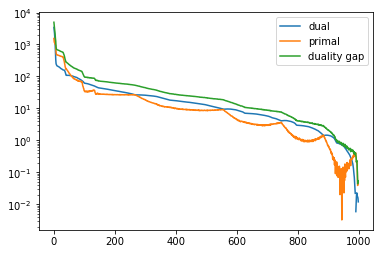

In [25]:
plt.plot(np.arange(len(dual_vals[-1])), dual_vals[-1] - np.min(dual_vals[-1]), label='dual')
plt.plot(np.arange(len(primal_vals[-1])), primal_vals[-1] - np.min(primal_vals[-1]), label='primal')
plt.plot(np.arange(len(result['duality_gap_history'])), 
         result['duality_gap_history'] - np.min(result['duality_gap_history']), 
         label='duality gap')

plt.legend()
plt.yscale('log')
plt.show()

### end for stable dynamic